# Estimation of level sets with BoTorch

following the entry level tutorial here https://botorch.org but I have also browsed extensively along Bite-sized and full-loop tutorials

## 1. Low dimension / low data (no fancy sampling)

Problem in 1-d: $f_{BlackBox}(x) = 2*sin(x) - x$ at threshold $t=3.$

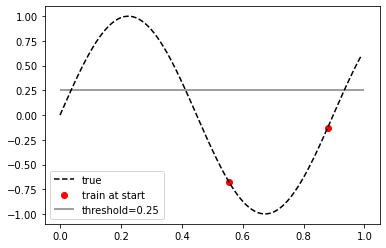

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import Tensor
from botorch.utils import standardize

def f(x: Tensor):
    return torch.sin(7*x)
    
t = 0.25

#generate truth data
true_x = torch.arange(0, 1, 0.01).double()
true_y = f(true_x).double()

#generate std training data
train_x = torch.rand(2,1).double()
train_y = f(train_x).double()
train_y_std = standardize(train_y).double()
noise = torch.full_like(train_y, 0.)
#plot
plt.plot(true_x, true_y, color='black', linestyle='--', label='true');
plt.scatter(train_x, train_y, color='red', marker='o', label='train at start')
plt.hlines(t, 0, 1, color='grey', label=f'threshold={t}');
plt.legend();

In [2]:
#train model 
from botorch.models import FixedNoiseGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood

gp = FixedNoiseGP(train_x, train_y, noise);
mll = ExactMarginalLogLikelihood(gp.likelihood, gp);
fit_gpytorch_model(mll);

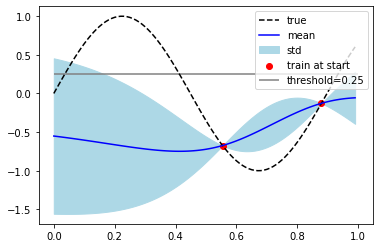

In [3]:
#plot fit
import numpy as np
mean = gp.posterior(true_x).mean.detach().numpy().flatten()
std = np.sqrt(gp.posterior(true_x).variance.detach().numpy().flatten())
plt.plot(true_x, true_y, color='black', linestyle='--', label='true');
plt.plot(true_x, mean, color='blue', label='mean');
plt.fill_between(true_x, mean-std, mean+std, color='lightblue', label='std');
plt.scatter(train_x, train_y, color='red', marker='o', label='train at start')
plt.hlines(0.25, 0, 1, color='grey', label='threshold=0.25');
plt.legend();

In [4]:
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.acquisition.objective import ScalarizedObjective
from botorch.models.model import Model
from typing import Optional
import numpy as np
import math

def cdf(mu, sigma, t):
    #DEBUG: use torch.erfc for numerical stability?
    print(f"t {t.shape} {t}")
    print(f"mu {mu.shape} {mu}")
    mu_changed = torch.stack([mu,mu], dim=1)
    sigma_changed = torch.stack([sigma, sigma], dim=1)
    print(f"mu_changed {mu_changed.shape} ")
    erf = torch.erf((t - mu_changed) * (sigma_changed).reciprocal() / math.sqrt(2))
    cdf = 0.5 * (1 + erf)
    return cdf 

class MaximumEntropySearch(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: Model,
        threshold: Tensor,
        objective: Optional[ScalarizedObjective] = None,
        maximize: bool = True,
    ) -> None:
        # TODO: dirty code ahead
        super().__init__(model=model, objective=objective)
        self.maximize = maximize
        self.thr = threshold
        infty = 1E10
        self.thresholds = [-infty] + self.thr.tolist() + [infty]
        self.pairs_thresholds = list(zip(self.thresholds, self.thresholds[1:]))
        self.pairs_thresholds = [torch.Tensor(pair) for pair in self.pairs_thresholds]

    def forward(self, X: Tensor):
        # TODO: dirty code ahead
        X.requires_grad=True
        
        posterior = self._get_posterior(X=X)
        batch_shape = X.shape[:-2]
        mean = posterior.mean.view(batch_shape).double()
        std = torch.square(posterior.variance.view(batch_shape).double())
    
        #probability of image being between thresholds
        p = cdf(mean, std, self.pairs_thresholds[1]) - cdf(mean, std, self.pairs_thresholds[0])
        probs = torch.cat([p, 1-p])
        #create bernoulli distribution
        distr = torch.distributions.Categorical(probs)
        #entropy
        entropy = distr.entropy().view(-1)
        return entropy

In [5]:
threshold = torch.Tensor([t]) 
threshold.requires_grad=True
MES = MaximumEntropySearch(gp, threshold=threshold)

In [6]:
from botorch.optim import optimize_acqf

bounds = torch.stack([torch.zeros(1), torch.ones(1)])

candidate, acq_value = optimize_acqf(
    MES, bounds=bounds, q=1, num_restarts=2, raw_samples=7,
)

print(f"candidate {candidate} acq_value {acq_value}")

t torch.Size([2]) tensor([2.5000e-01, 1.0000e+10])
mu torch.Size([7]) tensor([-0.7393, -0.0749, -0.6691, -0.6311, -0.5874, -0.3695, -0.3028],
       dtype=torch.float64)
mu_changed torch.Size([7, 2]) 
t torch.Size([2]) tensor([-1.0000e+10,  2.5000e-01])
mu torch.Size([7]) tensor([-0.7393, -0.0749, -0.6691, -0.6311, -0.5874, -0.3695, -0.3028],
       dtype=torch.float64)
mu_changed torch.Size([7, 2]) 
t torch.Size([2]) tensor([2.5000e-01, 1.0000e+10])
mu torch.Size([1]) tensor([-0.5874], dtype=torch.float64, grad_fn=<ViewBackward>)
mu_changed torch.Size([1, 2]) 
t torch.Size([2]) tensor([-1.0000e+10,  2.5000e-01])
mu torch.Size([1]) tensor([-0.5874], dtype=torch.float64, grad_fn=<ViewBackward>)
mu_changed torch.Size([1, 2]) 
t torch.Size([2]) tensor([2.5000e-01, 1.0000e+10])
mu torch.Size([1]) tensor([-0.5512], dtype=torch.float64, grad_fn=<ViewBackward>)
mu_changed torch.Size([1, 2]) 
t torch.Size([2]) tensor([-1.0000e+10,  2.5000e-01])
mu torch.Size([1]) tensor([-0.5512], dtype=torch.

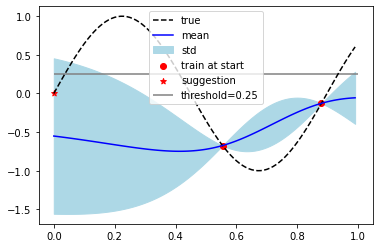

In [7]:
#plot fit
import numpy as np
mean = gp.posterior(true_x).mean.detach().numpy().flatten()
std = np.sqrt(gp.posterior(true_x).variance.detach().numpy().flatten())
plt.plot(true_x, true_y, color='black', linestyle='--', label='true');
plt.plot(true_x, mean, color='blue', label='mean');
plt.fill_between(true_x, mean-std, mean+std, color='lightblue', label='std');
plt.scatter(train_x, train_y, color='red', marker='o', label='train at start')
plt.scatter(candidate.detach().numpy(), f(candidate).detach().numpy(), color='red', marker='*', label='suggestion')
plt.hlines(0.25, 0, 1, color='grey', label='threshold=0.25');
plt.legend();